## AG News: Masked Language Modeling

Dataset Source: https://www.kaggle.com/datasets/thedevastator/new-dataset-for-text-classification-ag-news?select=train.csv

#### Install Necessary & Missing Libraries

In [1]:
%pip install --upgrade datasets evaluate transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━

#### Import Necessary Libraries

In [2]:
import os, sys, random, math

import pandas as pd

import matplotlib.pyplot as plt

import torch

import datasets
from datasets import ClassLabel, Dataset, DatasetDict

import transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer, set_seed

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### HuggingFace Access

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Display Library Versions

In [4]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.16
        Pandas: 1.4.4
      Datasets: 2.10.1
  Transformers: 4.26.1


#### Mount Google Drive

In [5]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


#### Load Training Dataset

In [6]:
parent_dir = "/content/drive/MyDrive/Projects/MLM - AG News"

train_data_file = os.path.join(parent_dir, "train.csv")

train_data = pd.read_csv(train_data_file, usecols=["text"])

train_data

,text
0,Wall St. Bears Claw Back Into the Black (Reute...
1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,Iraq Halts Oil Exports from Main Southern Pipe...
4,"Oil prices soar to all-time record, posing new..."
...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...
119996,Renteria signing a top-shelf deal Red Sox gene...
119997,Saban not going to Dolphins yet The Miami Dolp...
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...


#### Load Evaluation Dataset

In [7]:
eval_data_file = os.path.join(parent_dir, "test.csv")

eval_data = pd.read_csv(eval_data_file, usecols=["text"])

eval_data

,text
0,Fears for T N pension after talks Unions repre...
1,The Race is On: Second Private Team Sets Launc...
2,Ky. Company Wins Grant to Study Peptides (AP) ...
3,Prediction Unit Helps Forecast Wildfires (AP) ...
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...
...,...
7595,Around the world Ukrainian presidential candid...
7596,Void is filled with Clement With the supply of...
7597,Martinez leaves bitter Like Roger Clemens did ...
7598,5 of arthritis patients in Singapore take Bext...


#### Visual: Histogram of Input Lengths

The maximum length of this dataset is approximately 177 words.


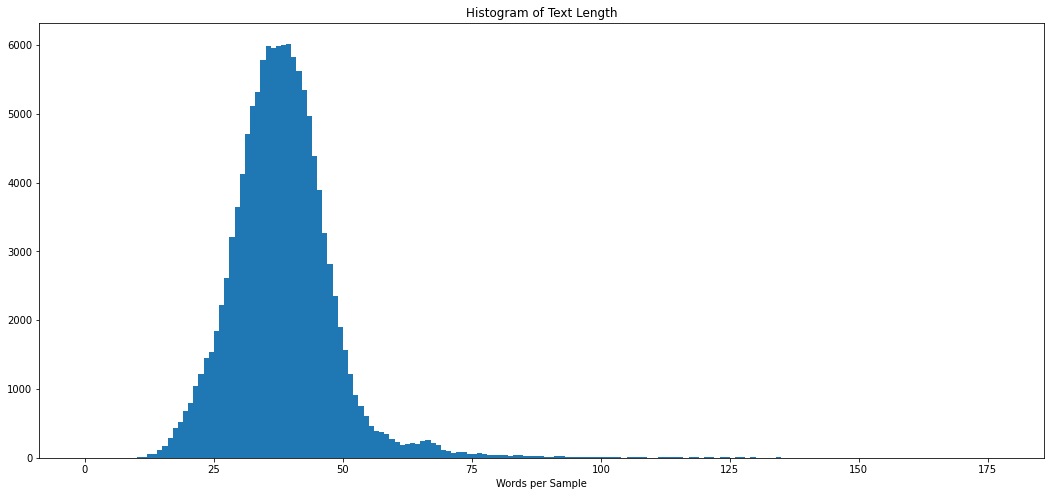

In [8]:
train_data['input_len'] = train_data['text'].str.split().str.len()
eval_data['input_len'] = eval_data['text'].str.split().str.len()

max_len = max(max(train_data['input_len']), max(eval_data['input_len']))
print(f"The maximum length of this dataset is approximately {max_len} words.")

input_lengths = pd.DataFrame()
input_lengths = pd.concat([train_data['input_len'], eval_data['input_len']])

n = max_len
input_lengths.hist(grid=False, figsize=(18,8), range=(0, n), bins=n)
plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Sample')
plt.show()

#### Remove Unnecessary Features

In [9]:
train_data = train_data.drop(columns=["input_len"])
eval_data = eval_data.drop(columns=["input_len"])

train_data.info()
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
dtypes: object(1)
memory usage: 937.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7600 non-null   object
dtypes: object(1)
memory usage: 59.5+ KB


#### Convert DataFrame to Dataset

In [10]:
training_dataset = Dataset.from_pandas(train_data)
evaluation_dataset = Dataset.from_pandas(eval_data)

#### Split Dataset into Training & Evaluation Datasets

In [11]:
ds = DatasetDict({
    'train' : training_dataset,
    'eval' : evaluation_dataset
})

print('Training data shape:', ds['train'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (120000, 1)
Eval data shape: (7600, 1)


#### Basic Values/Constants

In [12]:
BLOCK_SIZE = 128
MODEL_CKPT = "bert-base-uncased"

MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Masked_Language_Modeling-AG_News"
set_seed = 42

BATCH_SIZE = 1000
NUM_OF_EPOCHS = 3

WEIGHT_DECAY = 0.01
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
LEARNING_RATE = 2e-5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Tokenize Entire Dataset

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, use_fast=True, max_length=1024)

def tokenizer_function(samples):
    return tokenizer(samples["text"])

#### Apply Tokenizer Function to Entire Dataset

In [14]:
tokenized_ds = ds.map(tokenizer_function, 
                      batched=True,
                      num_proc=4,
                      remove_columns=["text"])

print(tokenized_ds["train"])
print(tokenized_ds["eval"])

Map (num_proc=4):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 120000
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7600
})


#### Preprocess Tokenized Dataset

In [15]:
def group_texts(samples):
    concatenated_samples = {k: sum(samples[k], []) for k in samples.keys()}
    total_length = len(concatenated_samples[list(samples.keys())[0]])
    
    if total_length >= BLOCK_SIZE:
        total_length = (total_length // BLOCK_SIZE) * BLOCK_SIZE
    
    result = {
        k: [t[i : i + BLOCK_SIZE] for i in range(0, total_length, BLOCK_SIZE)]
        for k, t in concatenated_samples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

#### Apply Preprocessing Function to Dataset

In [16]:
mlm_ds = tokenized_ds.map(
    group_texts,
    batched=True,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7600 [00:00<?, ? examples/s]

#### Instantiate Model

In [17]:
model = (
    AutoModelForMaskedLM.from_pretrained(MODEL_CKPT)
    ).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Define TrainingArguments

In [18]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=NUM_OF_EPOCHS,
    report_to=REPORTS_TO,
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [19]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

#### Instantiate Trainer

In [20]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=mlm_ds["train"],
    eval_dataset=mlm_ds["eval"],
    data_collator=data_collator
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-AG_News into local empty directory.


#### Train Model

In [21]:
train_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 49784
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18669
  Number of trainable parameters = 109514298
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,2.250000,1.912950
2,1.962600,1.787927
3,1.866300,1.744333


***** Running Evaluation *****
  Num examples = 3128
  Batch size = 8
Saving model checkpoint to bert-base-uncased-Masked_Language_Modeling-AG_News/checkpoint-6223
Configuration saved in bert-base-uncased-Masked_Language_Modeling-AG_News/checkpoint-6223/config.json
Configuration saved in bert-base-uncased-Masked_Language_Modeling-AG_News/checkpoint-6223/generation_config.json
Model weights saved in bert-base-uncased-Masked_Language_Modeling-AG_News/checkpoint-6223/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3128
  Batch size = 8
Saving model checkpoint to bert-base-uncased-Masked_Language_Modeling-AG_News/checkpoint-12446
Configuration saved in bert-base-uncased-Masked_Language_Modeling-AG_News/checkpoint-12446/config.json
Configuration saved in bert-base-uncased-Masked_Language_Modeling-AG_News/checkpoint-12446/generation_config.json
Model weights saved in bert-base-uncased-Masked_Language_Modeling-AG_News/checkpoint-12446/pytorch_model.bin
***** Running Evaluati

#### Evaluate Model

In [22]:
evaluation_results = trainer.evaluate()
print(f"Perplexity: {math.exp(evaluation_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 3128
  Batch size = 8


Perplexity: 5.95


#### Push Model to HuggingFace Hub

In [23]:
trainer.push_to_hub()

Saving model checkpoint to bert-base-uncased-Masked_Language_Modeling-AG_News
Configuration saved in bert-base-uncased-Masked_Language_Modeling-AG_News/config.json
Configuration saved in bert-base-uncased-Masked_Language_Modeling-AG_News/generation_config.json
Model weights saved in bert-base-uncased-Masked_Language_Modeling-AG_News/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/418M [00:00<?, ?B/s]

Upload file runs/Mar15_03-38-26_5e07946b7103/events.out.tfevents.1678851512.5e07946b7103.238.0: 100%|#########…

Upload file runs/Mar15_03-38-26_5e07946b7103/events.out.tfevents.1678856640.5e07946b7103.238.2: 100%|#########…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-AG_News
   351a6fe..ef8ff4a  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-AG_News
   351a6fe..ef8ff4a  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Masked Language Modeling', 'type': 'fill-mask'}}
To https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-AG_News
   ef8ff4a..6cefe7b  main -> main

   ef8ff4a..6cefe7b  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-AG_News/commit/ef8ff4a98838ba3cba7bd77403ee3d01a9213079'

### Citations

- Model Checkpoint
> @article{DBLP:journals/corr/abs-1810-04805, author ={Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding},
  journal   = {CoRR},
  volume    = {abs/1810.04805},
  year      = {2018},
  url       = {http://arxiv.org/abs/1810.04805},
  archivePrefix = {arXiv},
  eprint    = {1810.04805},
  timestamp = {Tue, 30 Oct 2018 20:39:56 +0100},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

- Metric (Perplexity)
> @article{jelinek1977perplexity,
title={Perplexity—a measure of the difficulty of speech recognition tasks},
author={Jelinek, Fred and Mercer, Robert L and Bahl, Lalit R and Baker, James K},
journal={The Journal of the Acoustical Society of America},
volume={62},
number={S1},
pages={S63--S63},
year={1977},
publisher={Acoustical Society of America}
}

